### 1. Preparação dos Dados

#### Importando os arquivos CSV do dataset e as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Caminho para a pasta dos datasets
dataset_path = "dataset"

# Lista todos os arquivos CSV na pasta
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

# Cria um dicionário para armazenar os dataframes
dataframes = {}

# Importa todos os arquivos CSV como dataframes
for file in csv_files:
    df_name = file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(os.path.join(dataset_path, file))

customers_df = dataframes['customers']
order_items_df = dataframes['order_items']
sellers_df = dataframes['sellers']
products_df = dataframes['products']
product_category_name_translation_df = dataframes['product_category_name_translation']
order_payments_df = dataframes['order_payments']
orders_df = dataframes['orders']
order_reviews_df = dataframes['order_reviews']
geolocation_df = dataframes['geolocation']

#### Realizando a limpeza necessária 

In [2]:
for name, df in dataframes.items():
    print(f"{name}:")
    print(df.isnull().sum())
    print("-" * 40)

customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------------------
order_items:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------------------
sellers:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
----------------------------------------
products:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
---------------------------------------

In [3]:
for name, df in dataframes.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicatas")

customers: 0 duplicatas
order_items: 0 duplicatas
sellers: 0 duplicatas
products: 0 duplicatas
product_category_name_translation: 0 duplicatas
order_payments: 0 duplicatas
orders: 0 duplicatas
order_reviews: 0 duplicatas
geolocation: 261831 duplicatas


- Podemos perceber que nenhuma das colunas relevantes para a análise possuem valores nulos, ao mesmo tempo que somente as linhas de "geolocation"  
possuem duplicatas o que não é um problemas pois essa tabela contém as localizações dos vendedores e dos compradores que podem se repetir sem problemas  
- Também destaca-se a qualidade desses dados visto que ainda não foi necessária nenhuma modificação nos datasets

#### Fazendo a normalização das colunas

In [4]:
order_items_df.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [5]:
order_payments_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


- Dado o contexto o problema, os atributos que podem ser problemáticos numericamente e que talvez precisem ser normalizados podem estar relacionados a precificação  
mas analisando as estatísticas gerais das tabelas relacionadas a valores monetários vemos que existem outliers mas que condizem com o negócio

#### Criando um modelo relacional e conectando as tabelas adequadamente

- Como os problemas a serem resolvidos e as perguntas a serem respondidas diferem bastamtem optarei por realizar os JOINS "sob demanda", ou seja caso uma pergunta  
necessite de mais de uma tabela a conexão será realizada na resolução da pergunta. Caso seja possível reutilizarei as conexões para evitar processamento descessário  
  
- Para facilitar o entendimento dos dados produzi um diagrama Entidade-Relacionamento que servirá de guia para o projeto disponível no link:  
[diagrama](https://miro.com/app/board/uXjVI0LJsEA=/?share_link_id=70608596602)

![diagrama](diagrama.jpg)

### 2. Análise Exploratória de Dados 

#### a) volume de pedidos por mês / sazonalidade nas vendas

In [6]:
# Converter a coluna de data para datetime
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

# Criar coluna com número do mês
orders_df['mes'] = orders_df['order_purchase_timestamp'].dt.month

# Contar número de pedidos por mês (ignorando o ano)
total_por_mes = orders_df.groupby('mes').size().reset_index(name='num_pedidos')

# Adicionar nome dos meses
meses_nome = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
              'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

total_por_mes['mes_nome'] = total_por_mes['mes'].apply(lambda x: meses_nome[x-1])

# Exibir resultado
display(total_por_mes[['mes_nome', 'num_pedidos']])


,mes_nome,num_pedidos
0,Janeiro,8069
1,Fevereiro,8508
2,Março,9893
3,Abril,9343
4,Maio,10573
5,Junho,9412
6,Julho,10318
7,Agosto,10843
8,Setembro,4305
9,Outubro,4959


- Podemos afirmar que sim, existe sazonalidade nas vendas, o segundo quadrimestre possui a maior quantidade de pedidos e o terceiro quadrimestre possui um desempenho muito abaixo dos outros

#### b) distribuição do tempo de entrega dos pedidos

- Considerando o "tempo de entrega" o intervalo de dias entre a aprovação do pagamento e a chegada do produto

In [7]:
# Converter as colunas para datetime, se ainda não estiverem
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])

# Calcular a diferença em dias
orders_df['tempo_de_entrega'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.days
orders_df['tempo_de_entrega'] = orders_df['tempo_de_entrega'].fillna(0).astype(int)

display((orders_df.groupby('tempo_de_entrega')
                    .size().
                    reset_index(name='num_pedidos'))
                    .sort_values(by='num_pedidos', ascending=False)
                    .head(25))

media_tempo_entrega = (orders_df['tempo_de_entrega'].sum() / orders_df['tempo_de_entrega'].count())
print(f"Média de tempo de entrega (em dias): {media_tempo_entrega:.2f}")

,tempo_de_entrega,num_pedidos
14,7,7715
13,6,7580
15,8,6389
12,5,6176
16,9,5869
17,10,5406
11,4,4975
18,11,4819
19,12,4471
20,13,4333


Média de tempo de entrega (em dias): 11.29


- Temos que a maioria dos pedidos é entregue entre 5 a 20 dias com um número grande de entregas realizadas no mesmo dia, além disso temos em média  
11 dias para que o produto seja entregue

#### c) relação entre o valor do frete e a distância de entrega

- Para resolver essa pergunta utilizarei as tabelas "orders", "customers", "order_items" e "sellers" para obter respectivamente o "order_id", ("customer_city" e "customer_state"), "freight_value", ("seller_city" e "seller_state") e com esses dados poderei obter informações importantes sobre a distância de entrega

In [8]:
orders_customers = orders_df.merge(customers_df, on='customer_id', how='inner')[['order_id', 'customer_city', 'customer_state']]
display(orders_customers.head())

orders_customers_items = orders_customers.merge(order_items_df[['order_id', 'seller_id', 'freight_value']], on='order_id', how='inner')
display(orders_customers_items.head())

orders_customers_items_sellers = orders_customers_items.merge(
    sellers_df[['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)

orders_customers_items_sellers = orders_customers_items_sellers.drop(columns=['seller_id'])
display(orders_customers_items_sellers.head())

,order_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP


,order_id,customer_city,customer_state,seller_id,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA,289cdb325fb7e7f891c38608bf9e0962,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO,4869f7a5dfa277a7dca6462dcf3b52b2,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN,66922902710d126a0e7d26b0e3805106,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP,2c9e548be18521d1c43cde1c582c6de8,8.72


,order_id,customer_city,customer_state,freight_value,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP,8.72,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA,22.76,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO,19.22,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN,27.20,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP,8.72,mogi das cruzes,SP


- Dividirei os pedidos entre "Mesma Cidade", "Mesmo Estado", e "Mesma Região". Assim podemos ter uma visão mais geral das distâncias

In [9]:
orders_customers_items_sellers['same_city'] = np.where(
    orders_customers_items_sellers['customer_city'].str.lower() == orders_customers_items_sellers['seller_city'].str.lower(),
    'yes', 'no'
)
orders_customers_items_sellers['same_state'] = np.where(
    orders_customers_items_sellers['customer_state'].str.lower() == orders_customers_items_sellers['seller_state'].str.lower(),
    'yes', 'no'
)

estado_para_regiao = {
    'AC': 'NO', 'AP': 'NO', 'AM': 'NO', 'PA': 'NO', 'RO': 'NO', 'RR': 'NO', 'TO': 'NO',
    'AL': 'NE', 'BA': 'NE', 'CE': 'NE', 'MA': 'NE', 'PB': 'NE', 'PE': 'NE', 'PI': 'NE', 'RN': 'NE', 'SE': 'NE',
    'DF': 'CO', 'GO': 'CO', 'MT': 'CO', 'MS': 'CO',
    'ES': 'SE', 'MG': 'SE', 'RJ': 'SE', 'SP': 'SE',
    'PR': 'SU', 'RS': 'SU', 'SC': 'SU'
}

orders_customers_items_sellers['customer_region'] = orders_customers_items_sellers['customer_state'].map(
    estado_para_regiao
).fillna('Outros')

orders_customers_items_sellers['seller_region'] = orders_customers_items_sellers['seller_state'].map(
    estado_para_regiao
).fillna('Outros')

orders_customers_items_sellers['same_region'] = np.where(
    orders_customers_items_sellers['customer_region'] == orders_customers_items_sellers['seller_region'],
    'yes', 'no'
)

orders_customers_items_sellers 

,order_id,customer_city,customer_state,freight_value,seller_city,seller_state,same_city,same_state,customer_region,seller_region,same_region
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,SP,8.72,maua,SP,no,yes,SE,SE,yes
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,BA,22.76,belo horizonte,SP,no,no,NE,SE,no
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,GO,19.22,guariba,SP,no,no,CO,SE,no
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,RN,27.20,belo horizonte,MG,no,no,NE,SE,no
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,SP,8.72,mogi das cruzes,SP,no,yes,SE,SE,yes
...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,praia grande,SP,20.10,tupa,SP,no,yes,SE,SE,yes
112646,83c1379a015df1e13d02aae0204711ab,nova vicosa,BA,65.02,sao paulo,SP,no,no,NE,SE,no
112647,11c177c8e97725db2631073c19f07b62,japuiba,RJ,40.59,ilicinea,MG,no,no,SE,SE,yes
112648,11c177c8e97725db2631073c19f07b62,japuiba,RJ,40.59,ilicinea,MG,no,no,SE,SE,yes


- Com todas essas informações finalmente podemos analisar o valor do frete 

In [10]:
# Cálculo das médias de frete por localização
media_frete_mesma_cidade = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_city'] == 'yes', 'freight_value'
].mean()

media_frete_mesmo_estado = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_state'] == 'yes', 'freight_value'
].mean()

media_frete_mesma_regiao = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_region'] == 'yes', 'freight_value'
].mean()

media_frete_diferente_regiao = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_region'] == 'no', 'freight_value'
].mean()

# Exibição organizada dos resultados
print("🏷️  Média do valor do frete por localização:")
print("-----------------------------------------------")
print(f"🚚 Entregas na mesma cidade:        R$ {media_frete_mesma_cidade:.2f}")
print(f"🚛 Entregas no mesmo estado:        R$ {media_frete_mesmo_estado:.2f}")
print(f"🧭 Entregas na mesma região:        R$ {media_frete_mesma_regiao:.2f}")
print(f"🗺️  Entregas em regiões diferentes: R$ {media_frete_diferente_regiao:.2f}")


🏷️  Média do valor do frete por localização:
-----------------------------------------------
🚚 Entregas na mesma cidade:        R$ 10.90
🚛 Entregas no mesmo estado:        R$ 13.46
🧭 Entregas na mesma região:        R$ 16.54
🗺️  Entregas em regiões diferentes: R$ 25.72


#### d) categorias de produtos mais vendidos em termos de faturamento

Considerei os "produtos mais vendidos em termos de faturamento" como os "produtos que geraram mais receita". Para isso não utilizarei o "payment_value" pois contém incluso o valor do frete  
uma opção mais "limpa" é o ("price" x "order_item_id") pois obtemos o valor real do pedido

In [11]:
order_items_products = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')[['order_id', 'product_category_name', 'price', 'order_item_id']]
order_items_products['real_price'] = order_items_products['price'] * order_items_products['order_item_id']

order_items_products = order_items_products.drop(columns=['price', 'order_item_id', 'order_id'])
produtos_mais_vendidos = order_items_products.groupby(['product_category_name']).sum().reset_index()
produtos_vendidos_ordenados = order_items_products.rename(columns={'real_price': 'total_revenue'}).sort_values(by=['total_revenue'], ascending=False)

display(produtos_vendidos_ordenados.head(25))


,product_category_name,total_revenue
1654,telefonia_fixa,13440.00
1653,telefonia_fixa,11760.00
1652,telefonia_fixa,10080.00
1651,telefonia_fixa,8400.00
50771,telefonia_fixa,7160.00
3556,utilidades_domesticas,6735.00
112233,pcs,6729.00
1650,telefonia_fixa,6720.00
107841,artes,6499.00
19515,agro_industria_e_comercio,5934.60


- Temos então as categorias mostradas acima como aquelas que geram maior faturamento

#### e) estados brasileiros com o maior valor médio de pedido

- como "valor de pedido" é um termo mais abrangente desta vez podemos usar diretamente o "payment value"  
- considerarei como "estado do pedido "o "customer_state", ou seja onde o pedido chegará
- vou reutilizar o "orders_customers" do item c)

In [12]:
# orders_customers = orders_df.merge(customers_df, on='customer_id', how='inner')[['order_id', 'customer_city', 'customer_state']]

orders_customers_no_city = orders_customers.drop(columns=['customer_city'])
orders_customers_payments = orders_customers_no_city.merge(order_payments_df[['order_id', 'payment_value']], on='order_id', how='inner')
orders_customers_payments = orders_customers_payments.drop(columns=['order_id'])
valor_medio_por_estado = orders_customers_payments.groupby(['customer_state']).mean().reset_index()
valor_medio_por_estado = valor_medio_por_estado.rename(columns={'payment_value': 'payment_mean'}).sort_values(by=['payment_mean'], ascending=False)
valor_medio_por_estado['payment_mean'] = valor_medio_por_estado['payment_mean'].round(2)

display(valor_medio_por_estado.head(25))

,customer_state,payment_mean
14,PB,248.33
0,AC,234.29
20,RO,233.20
3,AP,232.33
1,AL,227.08
21,RR,218.80
13,PA,215.92
24,SE,208.44
16,PI,207.11
26,TO,204.27


- Temos então os estados gerados acima como aqueles com maior valor médio de pedido 

### 3. Solução de Problemas de Negócio 

#### 1. **Análise de Retenção**


#### 2. **Predição de Atraso**

#### 3. **Segmentação de Clientes**

#### 4. **Análise de Satisfação**

### 4. Visualização e Dashboards

#### 1. Evolução das vendas ao longo do tempo

- O estado de referência será o estado em que a venda foi efetuada, ou seja "seller_state"

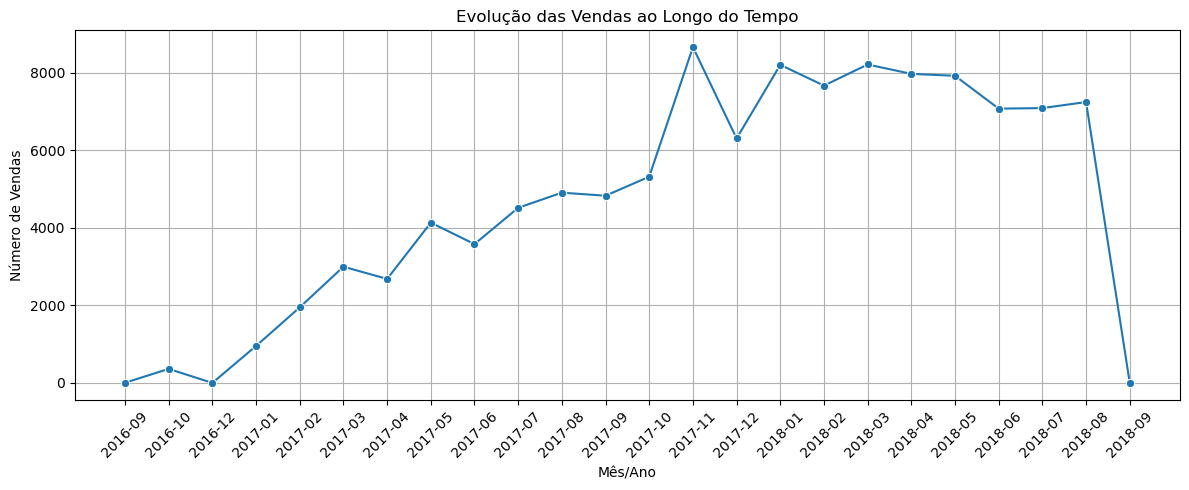

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento dos dados
orders_items = orders_df[['order_id', 'order_purchase_timestamp', 'tempo_de_entrega']].merge(
    order_items_df[['order_id', 'seller_id', 'product_id']], on='order_id', how='inner')

orders_items_products = orders_items.merge(
    products_df[['product_id', 'product_category_name']], on='product_id', how='inner')[
    ['order_id', 'order_purchase_timestamp', 'product_category_name', 'seller_id', 'tempo_de_entrega']]

orders_items_products_sellers = orders_items_products.merge(
    sellers_df[['seller_id', 'seller_state']], on='seller_id', how='inner')[
    ['order_id', 'seller_id', 'order_purchase_timestamp', 'product_category_name', 'seller_state', 'tempo_de_entrega']]

# Agrupar por mês e contar número de vendas
orders_items_products_sellers['mes_ano'] = orders_items_products_sellers['order_purchase_timestamp'].dt.to_period('M')
vendas_por_mes = orders_items_products_sellers.groupby('mes_ano').size().reset_index(name='num_vendas')
vendas_por_mes['mes_ano'] = vendas_por_mes['mes_ano'].astype(str)

# Plotar o gráfico
plt.figure(figsize=(12, 5))
sns.lineplot(data=vendas_por_mes, x='mes_ano', y='num_vendas', marker='o')
plt.title('Evolução das Vendas ao Longo do Tempo')
plt.xlabel('Mês/Ano')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- infelizmente os widgets de filtro não estão funcionando mas o gráfico saiu de maneira correta

#### 2. Concentração de vendas por região/estado do Brasil

In [14]:
import folium
from folium.plugins import HeatMap


orders_customers = orders_df[['order_id', 'customer_id']].merge(customers_df[['customer_id', 'customer_zip_code_prefix']], on='customer_id', how='inner')

orders_customers_geolocation = orders_customers.merge(geolocation_df[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']], 
                                                      left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

vendas_com_latitude_longitude = orders_customers_geolocation[['order_id', 'geolocation_lat', 'geolocation_lng']]

display(vendas_com_latitude_longitude.head(30))

# Amostra para evitar sobrecarga de memória (opcional)
sample_size = 50000
vendas_sample = vendas_com_latitude_longitude.sample(n=sample_size, random_state=42)

# Criar o mapa centralizado no Brasil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Adicionar o HeatMap
HeatMap(
    data=vendas_sample[['geolocation_lat', 'geolocation_lng']].values,
    radius=8,
    blur=10,
    min_opacity=0.2,
    max_zoom=1
).add_to(m)

m

,order_id,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
1,e481f51cbdc54678b7cc49136f2d6af7,-23.578333,-46.587123
2,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
3,e481f51cbdc54678b7cc49136f2d6af7,-23.575033,-46.587451
4,e481f51cbdc54678b7cc49136f2d6af7,-23.580054,-46.586673
5,e481f51cbdc54678b7cc49136f2d6af7,-23.578333,-46.587123
6,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
7,e481f51cbdc54678b7cc49136f2d6af7,-23.576281,-46.587276
8,e481f51cbdc54678b7cc49136f2d6af7,-23.573954,-46.587331
9,e481f51cbdc54678b7cc49136f2d6af7,-23.579628,-46.586714


#### 3. Relação avaliação do cliente x tempo de entrega

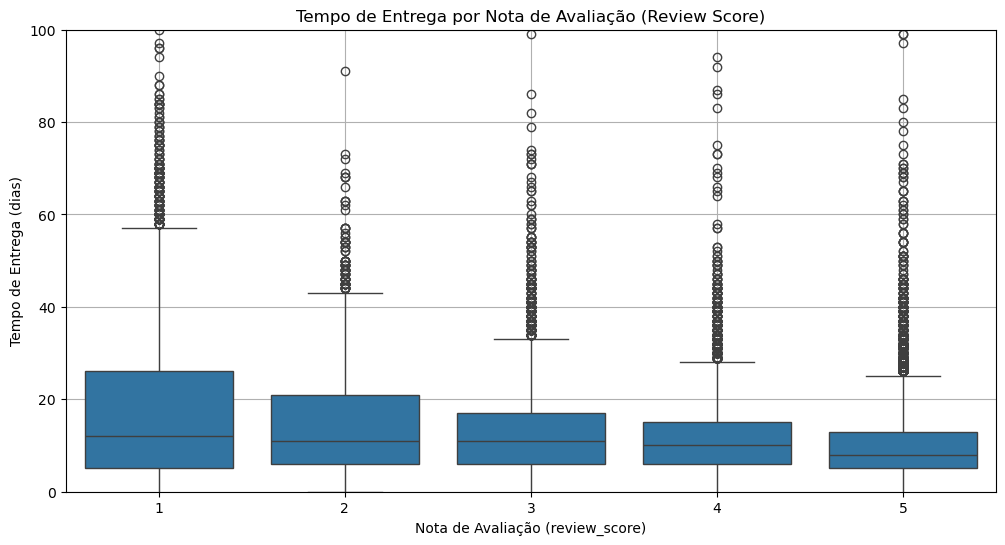

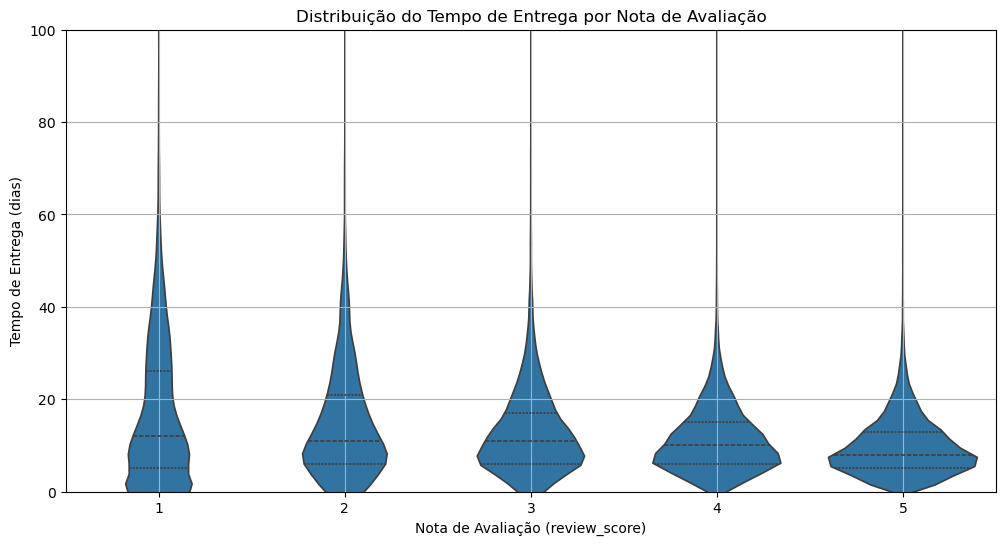

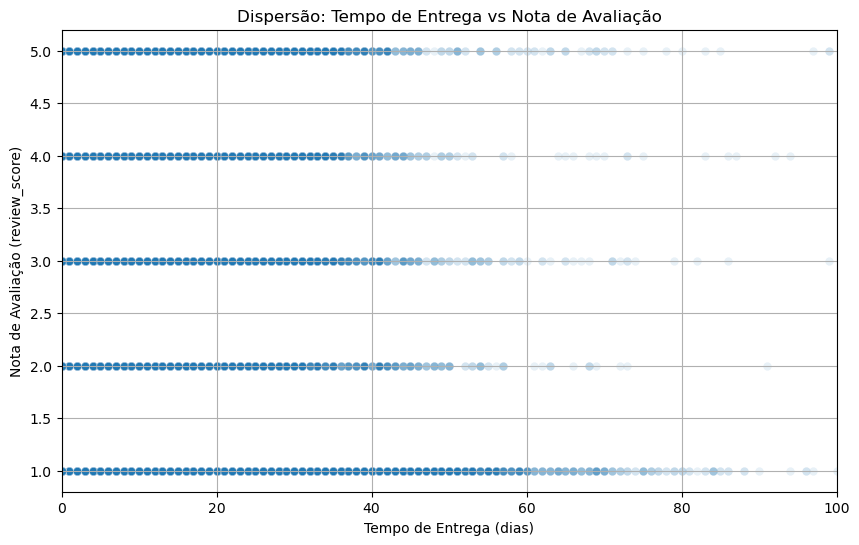

In [15]:
orders_reviews = orders_df[['order_id', 'tempo_de_entrega']].merge(
    order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')

orders_reviews.head(10)

plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score', y='tempo_de_entrega', data=orders_reviews)
plt.ylim(0, 100)
plt.title('Tempo de Entrega por Nota de Avaliação (Review Score)')
plt.xlabel('Nota de Avaliação (review_score)')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='review_score', y='tempo_de_entrega', data=orders_reviews, inner='quartile')
plt.ylim(0, 100)
plt.title('Distribuição do Tempo de Entrega por Nota de Avaliação')
plt.xlabel('Nota de Avaliação (review_score)')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tempo_de_entrega', y='review_score', data=orders_reviews, alpha=0.1)
plt.xlim(0, 100)
plt.title('Dispersão: Tempo de Entrega vs Nota de Avaliação')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Nota de Avaliação (review_score)')
plt.grid(True)
plt.show()


- É possível notar que pouca é a diferença entre o tempo de entrega para as notas 3, 4 e 5. No entanto, para as notas 1 e 2 podemos perceber um crescimento do tempo de entrega  

- Principalmente a partir do gráfico de violino podemos perceber a relação entre as duas variáveis


#### 4. Dashboard de análise dos vendedores

- Como temos 3090 vendedores distintos (ao realizarmos o merge das tabelas) vamos diminuir os escopo da nossa análise para os 50 "maiores" vendedores que são os 50  
com a maior quantidade de pedidos. Isso será feito por conta da relevância desses vendedores no dataset.  


- Poderiamos mostrar os top 50 vendedores considerando somente as "melhores avaliações" no entanto isso favoreceria vendedores com poucas vendas ou seja teriamos as "melhores avliações" de vendedores que venderam 1 a 5 produtos que é um volume irrelevante para o dataset. O mesmo vale para o tempo de entrega.

- Infelizmente não temos o nome dos vendedores o que torna os gráficos "poluídos". Poderiamos atribuir um "apelido" a cada vendedor ganhariamos legibilidade em detrimento da informação de quem são de fato os top 50 

Número de seller_id distintos: 3090


/tmp/ipykernel_4043/3070059393.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_25.index, y=top_25.values, palette='viridis')


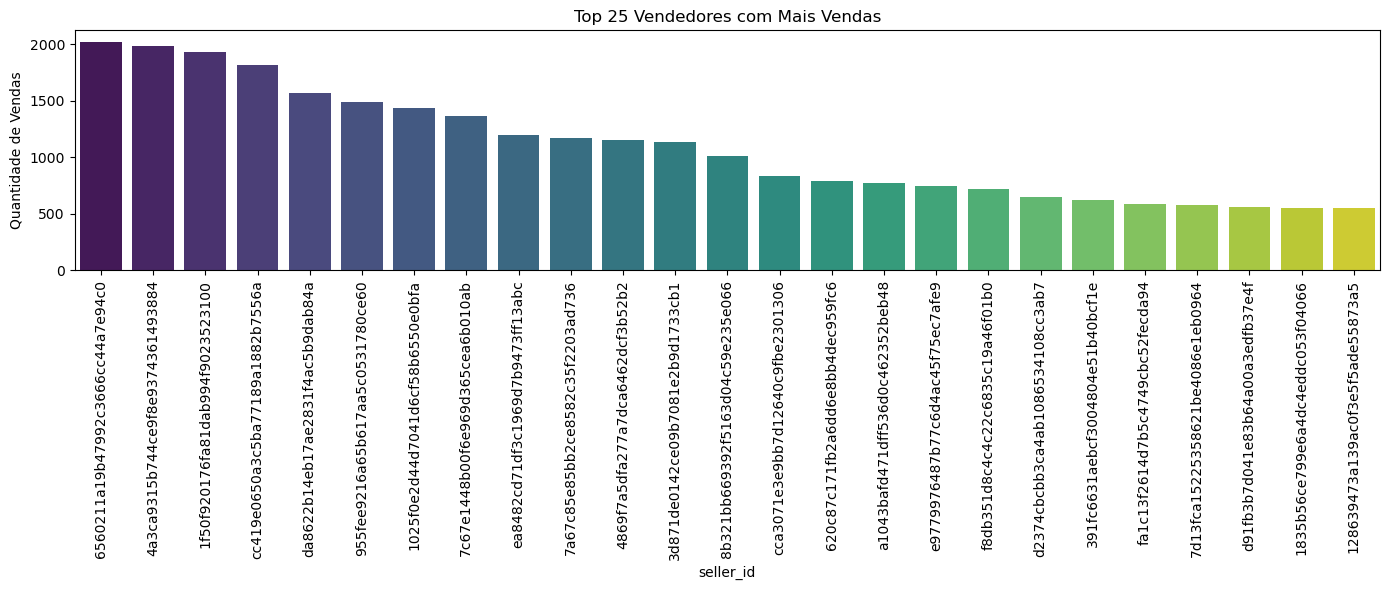

/tmp/ipykernel_4043/3070059393.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_reviews_top_25_sorted.index, y=media_reviews_top_25_sorted.values, palette='coolwarm')


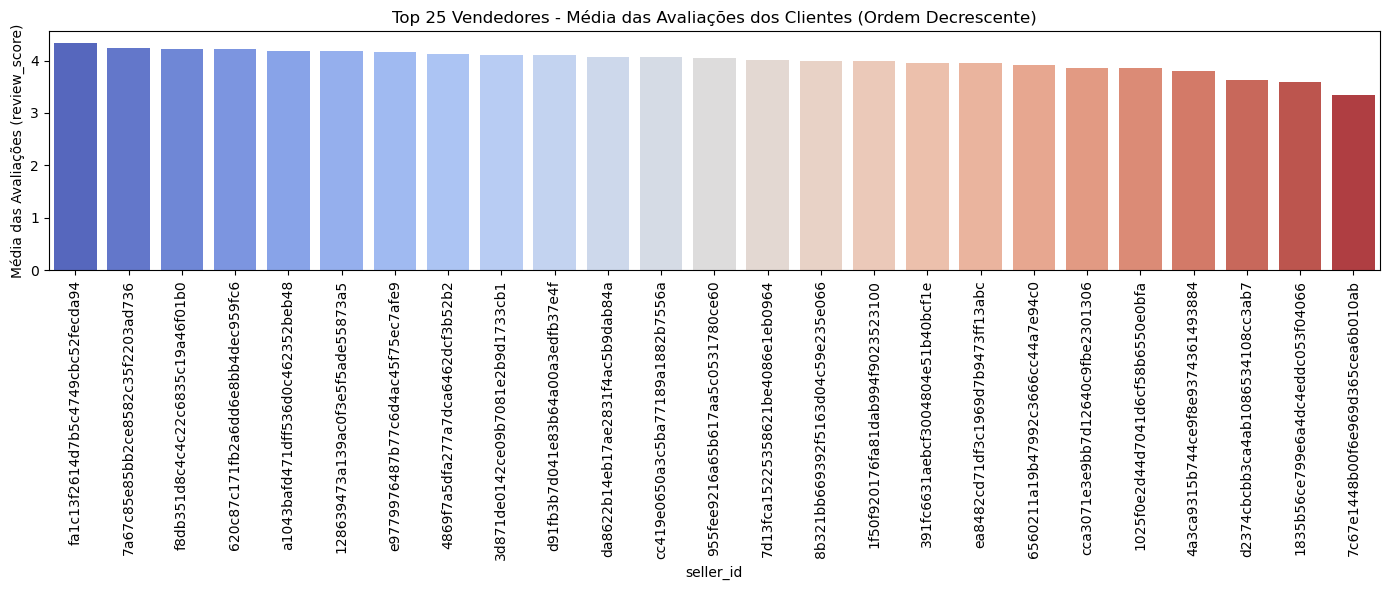

/tmp/ipykernel_4043/3070059393.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_tempo_entrega_top_25_sorted.index, y=media_tempo_entrega_top_25_sorted.values, palette='magma')


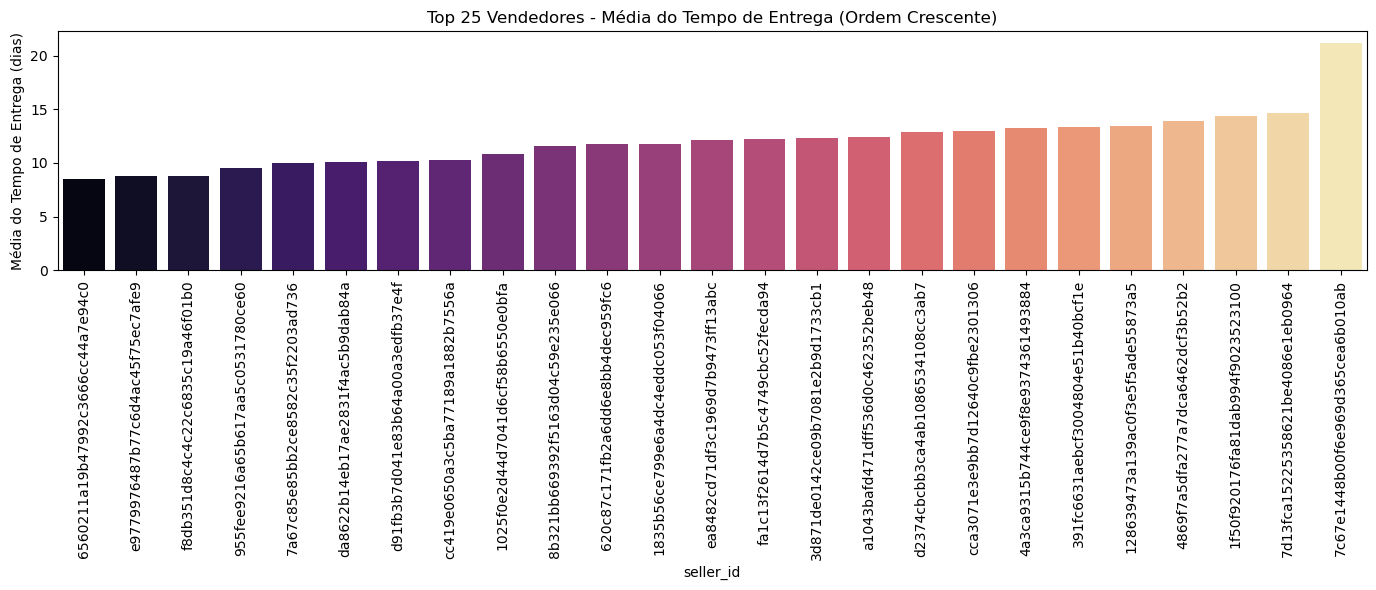

In [31]:
# volume de vendas, satisfação do cliente e tempo de entrega
analise_dos_vendedores = orders_items_products_sellers.drop(columns=['order_purchase_timestamp', 'seller_state', 'mes_ano', 'product_category_name'])
analise_dos_vendedores = analise_dos_vendedores.merge(order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')

# Quantidade de vendedores distintos
num_sellers = analise_dos_vendedores['seller_id'].nunique()
print(f"Número de seller_id distintos: {num_sellers}")

top_25 = analise_dos_vendedores['seller_id'].value_counts().head(25)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_25.index, y=top_25.values, palette='viridis')
plt.title('Top 25 Vendedores com Mais Vendas')
plt.xlabel('seller_id')
plt.ylabel('Quantidade de Vendas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calcular a média das reviews para os top 25 vendedores
media_reviews_top_25 = (
    analise_dos_vendedores[analise_dos_vendedores['seller_id'].isin(top_25.index)]
    .groupby('seller_id')['review_score']
    .mean()
    .loc[top_25.index]  # mantém a ordem dos top_25
)

# Ordenar em ordem decrescente de média das avaliações
media_reviews_top_25_sorted = media_reviews_top_25.sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=media_reviews_top_25_sorted.index, y=media_reviews_top_25_sorted.values, palette='coolwarm')
plt.title('Top 25 Vendedores - Média das Avaliações dos Clientes (Ordem Decrescente)')
plt.xlabel('seller_id')
plt.ylabel('Média das Avaliações (review_score)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calcular a média do tempo de entrega para os top 25 vendedores
media_tempo_entrega_top_25 = (
    analise_dos_vendedores[analise_dos_vendedores['seller_id'].isin(top_25.index)]
    .groupby('seller_id')['tempo_de_entrega']
    .mean()
    .loc[top_25.index]  # mantém a ordem dos top_25
)
# Ordenar em ordem crescente de média do tempo de entrega
media_tempo_entrega_top_25_sorted = media_tempo_entrega_top_25.sort_values(ascending=True)
plt.figure(figsize=(14, 6))
sns.barplot(x=media_tempo_entrega_top_25_sorted.index, y=media_tempo_entrega_top_25_sorted.values, palette='magma')
plt.title('Top 25 Vendedores - Média do Tempo de Entrega (Ordem Crescente)')
plt.xlabel('seller_id')
plt.ylabel('Média do Tempo de Entrega (dias)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

